In [1]:
import treescope
import torch
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataset, ConcatDESRES
from src.configs import ModelArgs # noqa
from torch.utils.data import RandomSampler
from torch_geometric.loader import DataLoader
from loguru import logger
from dataclasses import asdict
import linear_operator_learning as lol
import matplotlib.pyplot as plt
import numpy as np
import pickle


#treescope.basic_interactive_setup()

### MultiTask Dataset

In [22]:
from mlcolvar.data.graph.atomic import AtomicNumberTable

datasets = [
    DESRESDataset(protein_id)
    for protein_id in ['CLN025', '2JOF', '2F4K']
]
z_table = AtomicNumberTable(sorted(list(set(sum([ds.z_table.zs for ds in datasets], [])))))
for ds in datasets:
    ds.z_table = z_table
dataset = ConcatDESRES(datasets)

In [23]:
train_dataloader = DataLoader(
    dataset,
    batch_size=50,
    shuffle=True,
)

In [25]:
train_batch = next(iter(train_dataloader))

In [27]:
batch, system_ids = train_batch

In [28]:
mask = system_ids == 0

In [33]:
from torch_geometric.data import Batch
Batch.from_data_list(batch['item'][mask])

DataBatch(edge_index=[2, 38214], shifts=[38214, 3], unit_shifts=[38214, 3], positions=[1023, 3], cell=[33, 3], node_attrs=[1023, 4], n_system=[11, 1], n_env=[11, 1], weight=[11], batch=[1023], ptr=[12])

### Old

In [47]:
# Write new configs on wandb.
import wandb

protein_id = "CLN025"
traj_id = 0
api = wandb.Api()

for run in api.runs(f"csml/encoderops-{protein_id}-{traj_id}"):
    updated: bool = False
    if run.state == "finished":
        data_path = Path(f"logs/encoderops-{protein_id}-{traj_id}/{run.id}")
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/epoch=last.ckpt")))
        model_args = asdict(model.model_args)
        for k, v in model_args.items():
            if k not in run.config:
                run.config[k] = v
                updated = True
        run.update()
        if updated:
            logger.info(f"Updated run {run.id}")
        else:
            logger.info(f"Run {run.id} was already up to date")

StopIteration: 

In [170]:
def load_run(run_id: str, protein_id: str, traj_id:int = 0, epoch: int | None = None, progress: bool = True, subsample: float | None = None):
    reg=1e-4
    data_path = Path(f"logs/encoderops-{protein_id}-{traj_id}/{run_id}")
    if epoch is None:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/last.ckpt")))
    else:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)
    embeddings = {"t": [], "lag": []}
    model = model.eval()
    if subsample is not None:
        num_samples = int(len(dataset)*subsample)
        sampler = RandomSampler(dataset, num_samples=num_samples)
        dataloader = DataLoader(dataset, batch_size=128, sampler=sampler)
    else:
        dataloader = DataLoader(
            dataset, batch_size=128, shuffle=False
        )

    with torch.no_grad():
        if progress:
            from tqdm.auto import tqdm
            dataloader = tqdm(dataloader)
        for batch in dataloader:
            for k, v in batch.items():
                batch[k] = v.to(model.device)
            # data
            x_t = model._setup_graph_data(batch)
            x_lag = model._setup_graph_data(batch, key="item_lag")
            # forward
            f_t = model.forward_nn(x_t)
            f_lag = model.forward_nn(x_lag)
            embeddings["t"].append((f_t.detach().cpu()))
            embeddings["lag"].append((f_lag.detach().cpu()))
    phi_t = torch.cat(embeddings["t"])
    phi_lag = torch.cat(embeddings["lag"])
    logger.info(f"model mean {model.f_mean}\nstat mean {phi_t.mean(dim=0)}\n diff {model.f_mean.to('cpu') - phi_t.mean(dim=0)}")
    cov_X = model.cov.to('cpu')
    cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
    cov_XY = model.cross_cov.to('cpu')
    G = torch.linalg.solve(cov_X, cov_XY)
    l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
    sort_perm = torch.argsort(l.abs(), descending=True)
    l = l[sort_perm]
    Q = Q[:, sort_perm]
    r_fun = phi_t.to(dtype=Q.dtype) @ Q 
    results = {
        "embedding_t": phi_t,
        "embedding_lag": phi_lag,
        "eigenvalues": l,
        "eigenvectors": Q,
        "r_fun": r_fun
    }
    return model, results

In [239]:
protein_id = "CLN025"
run_id = "uuaz2hv8"
model, results = load_run(run_id, protein_id, subsample=0.04)

100%|██████████| 168/168 [01:31<00:00,  1.83it/s]
2025-05-05 15:39:44.746 | INFO     | __main__:load_run:37 - model mean tensor([0.4967, 0.5033, 0.5198, 0.4802, 0.5240, 0.4760, 0.5076, 0.4924, 0.4588,
        0.5412, 0.5192, 0.4808, 0.5412, 0.4588, 0.4890, 0.5110, 0.5085, 0.4915,
        0.5166, 0.4834, 0.5203, 0.4797, 0.5216, 0.4784, 0.5288, 0.4712, 0.4894,
        0.5106, 0.5162, 0.4838, 0.5197, 0.4803, 0.4781, 0.5219, 0.4980, 0.5020,
        0.5057, 0.4943, 0.4964, 0.5036, 0.5007, 0.4993, 0.4732, 0.5268, 0.5176,
        0.4824, 0.4827, 0.5173, 0.4714, 0.5286, 0.5064, 0.4936, 0.5234, 0.4766,
        0.4842, 0.5158, 0.4771, 0.5229, 0.4570, 0.5430, 0.4901, 0.5099, 0.5040,
        0.4960], device='cuda:0')
stat mean tensor([0.4942, 0.5058, 0.4925, 0.5075, 0.5231, 0.4769, 0.5237, 0.4763, 0.4653,
        0.5347, 0.5030, 0.4970, 0.5331, 0.4669, 0.4603, 0.5397, 0.5230, 0.4770,
        0.5153, 0.4847, 0.5324, 0.4676, 0.5478, 0.4522, 0.5158, 0.4842, 0.4936,
        0.5064, 0.5140, 0.4860, 0.5

In [240]:
def implied_timescale(ev, lagtime_ns: float = 0.2):
    if torch.is_tensor(ev):
        ev = ev.numpy(force=True)
    timescale = -1*(lagtime_ns / np.log(np.abs(ev)))
    return np.sort(timescale)[::-1]

(-1.0994713695023444,
 1.0999748271191592,
 -1.0998615404412626,
 1.0998615404412626)

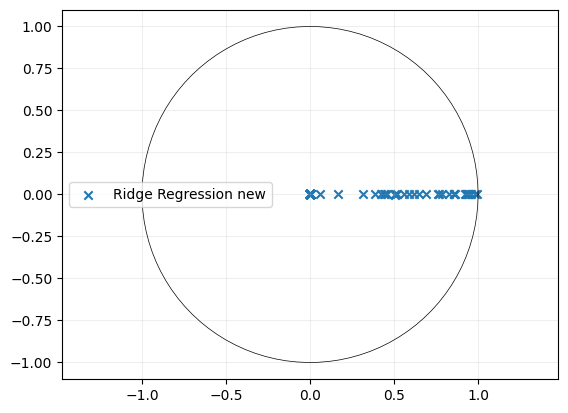

In [245]:
plt.scatter(results['eigenvalues'].real, results['eigenvalues'].imag, marker='x', label="Ridge Regression new")
#plt.scatter(e1.real, e1.imag, label="end2end")
plt.grid(alpha=0.2)
plt.legend()
# Draw unit circle
t = np.linspace(0, 2 * np.pi, 100)
r = 1
x = r * np.cos(t)
y = r * np.sin(t)
plt.plot(x, y, color='k', lw=0.5)
plt.axis('equal')

In [246]:
from mlcolvar.utils.fes import compute_fes

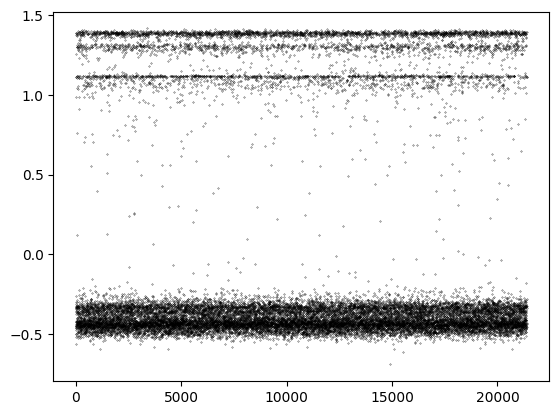

In [247]:
r_fun = results['r_fun']
plt.plot(r_fun[:, 0].real, '.', color='k', markersize = 0.5)
#plt.axhline(1.55, color='r')

Text(0.5, 0, 'Deep-TICA 2')

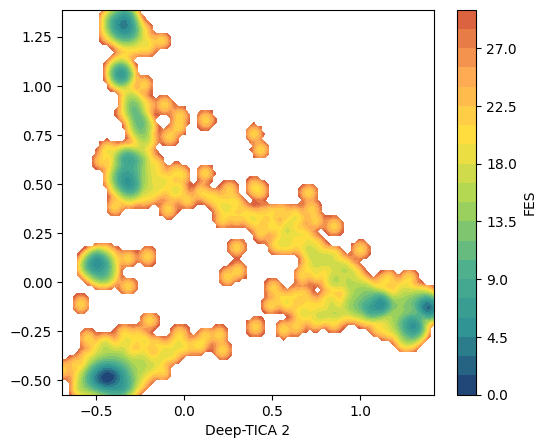

In [249]:
fig,ax = plt.subplots(1,1,figsize=(6,5),dpi=100)
max_fes = 30
# compute cvs
with torch.no_grad():
    s = torch.stack([r_fun[:, idx].real for idx in idxs]).T
fes,grid,bounds,error = compute_fes(s,
    blocks=1,
    bandwidth=0.01, scale_by='range',
    plot=False, plot_max_fes=200, ax = ax, eps=1e-10)

fes2 = fes.copy()
if max_fes is not None:
    fes2[fes2 > max_fes] = np.nan
extent = [item for sublist in bounds for item in sublist]
pp = ax.contourf(fes2, levels=20, cmap="fessa", extent=extent)  # ,vmax=max_fes)
cbar = plt.colorbar(pp, ax=ax)
cbar.set_label("FES")
# ax.set_xlim(-3, 2)
# ax.set_ylim(-3, 2)
ax.set_xlabel('Deep-TICA 1')
ax.set_xlabel('Deep-TICA 2')

Text(0, 0.5, 'Tica-2 $\\tau=$4.35ns')

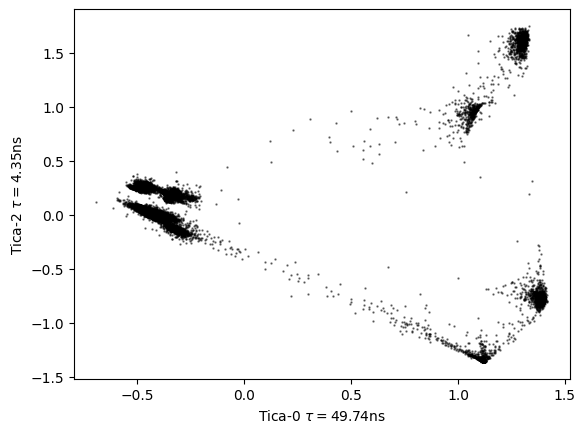

In [261]:
idxs = (0, 2)
plt.scatter(r_fun[:, idxs[0]].real, r_fun[:, idxs[1]].real, color='k', s = 0.5, alpha=0.5)
taus = implied_timescale(results['eigenvalues'])
plt.xlabel(f'Tica-{idxs[0]} $\\tau=${taus[idxs[0]]:.2f}ns')
plt.ylabel(f'Tica-{idxs[1]} $\\tau=${taus[idxs[1]]:.2f}ns')
#plt.axvline(1.55, color='r')

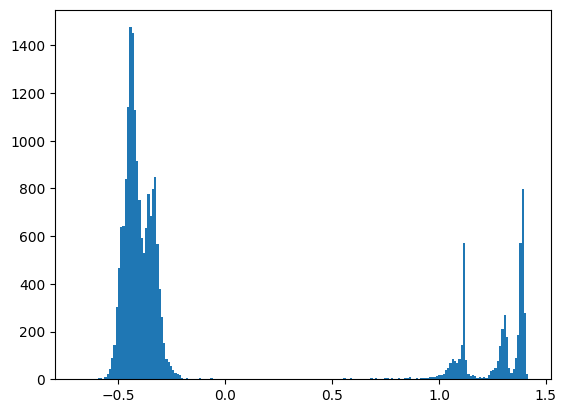

In [262]:
plt.hist(r_fun[:, 0].real, bins=200);

In [ ]:
np.mean((r_fun[:, 0].real < 0).numpy())

0.7792323156762822

: 

In [163]:
for idx, t in enumerate(implied_timescale(results['eigenvalues'])):
    if idx < 10:
        print(f"{idx:<3} | {t:.2f}ns")


0   | 29.91ns
1   | 9.45ns
2   | 2.99ns
3   | 2.67ns
4   | 2.20ns
5   | 1.90ns
6   | 1.59ns
7   | 1.53ns
8   | 1.43ns
9   | 1.37ns
